In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import wget

In [2]:
if not os.path.exists('vae-cvae-challenge.npz'):
    url = 'https://git.imp.fu-berlin.de/yuxuac94/'\
          'deep-learning-examples/-/raw/master/'\
          '02-Intermediate/vae-cvae-challenge.npz'
    wget.download(url, './vae-cvae-challenge.npz')

# load data
with np.load('vae-cvae-challenge.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

(20000, 784) float32
(20000,) int64


In [3]:
# hyper-parameters
input_size = 784
hidden_size = 256
latent_size = 2
num_classes = 10
num_epochs = 20
batch_size = 50
learning_rate = 0.002
weight_decay = 0

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# create dataloader
data_loader = tf.data.Dataset.from_tensor_slices((data_x, data_y))
data_loader = data_loader.shuffle(
    buffer_size=data_x.shape[0], 
    reshuffle_each_iteration=True
).batch(batch_size)

In [5]:
class VAE(keras.Model):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.hidden_encoder = Dense(hidden_size, 
                                    activation=tf.nn.relu)
        self.mu_encoder = Dense(units=latent_size)
        self.var_encoder = Dense(units=latent_size)

        self.latent_decoder = Dense(hidden_size, 
                                    activation=tf.nn.relu)
        self.hidden_decoder = Dense(input_size, 
                                    activation=tf.nn.sigmoid)
           
    def encode(self, x):
        hidden = self.hidden_encoder(x)
        mu = self.mu_encoder(hidden)
        log_var = self.var_encoder(hidden)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = tf.math.exp(log_var/2)
        eps = tf.random.normal([self.latent_size])
        z = mu + eps * std
        return z
    
    def decode(self, z):
        hidden = self.latent_decoder(z)
        reconstruct = self.hidden_decoder(hidden)
        return reconstruct

    def call(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var, z

In [6]:
class CVAE(keras.Model):
    def __init__(self, input_size, hidden_size, 
                 latent_size, num_classes):
        super(CVAE, self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        self.hidden_encoder = Dense(hidden_size, 
                                    activation=tf.nn.relu)
        self.mu_encoder = Dense(latent_size)
        self.var_encoder = Dense(latent_size)

        self.latent_decoder = Dense(hidden_size, 
                                    activation=tf.nn.relu)
        self.hidden_decoder = Dense(input_size, 
                                    activation=tf.nn.sigmoid)
            
    def encode(self, x, y):
        # concatenate label:y with input:x
        y = tf.one_hot(y, self.num_classes)
        x = tf.concat([x, y], axis=-1)

        # foward pass of encoder
        hidden = self.hidden_encoder(x)
        mu = self.mu_encoder(hidden)
        log_var = self.var_encoder(hidden)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = tf.math.exp(log_var/2)
        eps = tf.random.normal([self.latent_size])
        z = mu + eps * std
        return z
    
    def decode(self, z, y):
        # concatenate latent and label
        y = tf.one_hot(y, self.num_classes)
        z = tf.concat([z, y], axis=-1)

        hidden = self.latent_decoder(z)
        reconstruct = self.hidden_decoder(hidden)
        return reconstruct

    def call(self, x, y):
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z, y)
        return out, mu, log_var, z

In [7]:
def kl_loss(mu, log_var, latent_size):
    loss = 0.5 * (
        tf.reduce_sum(tf.math.exp(log_var), axis=-1, keepdims=True) \
        + tf.reduce_sum(tf.square(mu), axis=-1, keepdims=True) \
        - latent_size \
        - tf.reduce_sum(log_var, axis=-1, keepdims=True))
    return tf.reduce_sum(loss)

In [8]:
# set model and optimizer of vae
vae = VAE(input_size=input_size,
          hidden_size=hidden_size,
          latent_size=latent_size)
vae_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [9]:
# start training vae
for epoch in range(num_epochs):
    for images, _ in data_loader:
        # forward pass
        with tf.GradientTape() as g:
            out, mu, log_var, _ = vae(images, training=True)
        
            # loss function consists of three parts:
            # 1.recontruction loss, 2. KL-regularizer, 3. L2
            #   1.reconstruction loss: cross entropy
            reconst_loss =  tf.reduce_sum(
                binary_crossentropy(images, out)) * (28*28)
            #   2. KL-regularizer
            kl_div = kl_loss(mu, log_var, latent_size)         
            #   3. L2 loss
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in vae.trainable_variables])

            # update loss
            vae_loss = reconst_loss + kl_div + l2_loss
        
        # b-p
        grad = g.gradient(vae_loss, vae.trainable_variables)
        vae_optimizer.apply_gradients(
            zip(grad, vae.trainable_variables))

    print ('Epoch[{}/{}], Reconst. Loss: {:.3f}, KL-Div: {:.3f}'.format(
    epoch+1, num_epochs, reconst_loss, kl_div))

Epoch[1/20], Reconst. Loss: 8443.771, KL-Div: 211.937
Epoch[2/20], Reconst. Loss: 8780.489, KL-Div: 216.588
Epoch[3/20], Reconst. Loss: 8199.584, KL-Div: 337.438
Epoch[4/20], Reconst. Loss: 7670.904, KL-Div: 290.580
Epoch[5/20], Reconst. Loss: 7550.951, KL-Div: 271.144
Epoch[6/20], Reconst. Loss: 8207.376, KL-Div: 272.000
Epoch[7/20], Reconst. Loss: 7492.862, KL-Div: 285.713
Epoch[8/20], Reconst. Loss: 7759.513, KL-Div: 274.192
Epoch[9/20], Reconst. Loss: 7368.451, KL-Div: 279.527
Epoch[10/20], Reconst. Loss: 7223.113, KL-Div: 302.329
Epoch[11/20], Reconst. Loss: 7381.292, KL-Div: 295.942
Epoch[12/20], Reconst. Loss: 7687.841, KL-Div: 285.445
Epoch[13/20], Reconst. Loss: 7462.984, KL-Div: 317.619
Epoch[14/20], Reconst. Loss: 7768.641, KL-Div: 294.808
Epoch[15/20], Reconst. Loss: 7263.040, KL-Div: 306.388
Epoch[16/20], Reconst. Loss: 7865.526, KL-Div: 295.156
Epoch[17/20], Reconst. Loss: 6886.177, KL-Div: 298.055
Epoch[18/20], Reconst. Loss: 7432.392, KL-Div: 317.981
Epoch[19/20], Recon

In [10]:
# set model and optimizer of vae
cvae = CVAE(input_size=input_size,
            hidden_size=hidden_size,
            latent_size=latent_size, 
            num_classes=num_classes)
cvae_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# start training cvae
for epoch in range(num_epochs):
    for images, labels in data_loader:
        # forward pass
        with tf.GradientTape() as g:
            out, mu, log_var, _ = cvae(images, labels, training=True)

            reconst_loss =  tf.reduce_sum(
                binary_crossentropy(images, out)) * (28*28)
            kl_div = kl_loss(mu, log_var, latent_size)
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in cvae.trainable_variables])

            # update loss
            cvae_loss = reconst_loss + kl_div + l2_loss
        
        # b-p
        grad = g.gradient(cvae_loss, cvae.trainable_variables)
        cvae_optimizer.apply_gradients(
            zip(grad, cvae.trainable_variables))

    print ('Epoch[{}/{}], Reconst. Loss: {:.3f}, KL-Div: {:.3f}'.format(
    epoch+1, num_epochs, reconst_loss, kl_div))

Epoch[1/20], Reconst. Loss: 7883.914, KL-Div: 185.866
Epoch[2/20], Reconst. Loss: 7447.838, KL-Div: 219.974
Epoch[3/20], Reconst. Loss: 6280.765, KL-Div: 257.281
Epoch[4/20], Reconst. Loss: 6840.196, KL-Div: 206.197
Epoch[5/20], Reconst. Loss: 6620.153, KL-Div: 190.532
Epoch[6/20], Reconst. Loss: 6333.264, KL-Div: 192.669
Epoch[7/20], Reconst. Loss: 6391.518, KL-Div: 218.652
Epoch[8/20], Reconst. Loss: 6941.926, KL-Div: 224.101
Epoch[9/20], Reconst. Loss: 6879.106, KL-Div: 200.114
Epoch[10/20], Reconst. Loss: 6573.193, KL-Div: 191.883
Epoch[11/20], Reconst. Loss: 6325.601, KL-Div: 237.952
Epoch[12/20], Reconst. Loss: 7251.812, KL-Div: 218.803
Epoch[13/20], Reconst. Loss: 6473.265, KL-Div: 205.875
Epoch[14/20], Reconst. Loss: 6440.257, KL-Div: 212.244
Epoch[15/20], Reconst. Loss: 5720.574, KL-Div: 224.619
Epoch[16/20], Reconst. Loss: 6608.249, KL-Div: 217.619
Epoch[17/20], Reconst. Loss: 6839.375, KL-Div: 231.525
Epoch[18/20], Reconst. Loss: 6857.502, KL-Div: 250.458
Epoch[19/20], Recon

###  Task 1: Study the encoding for VAE and CVAE

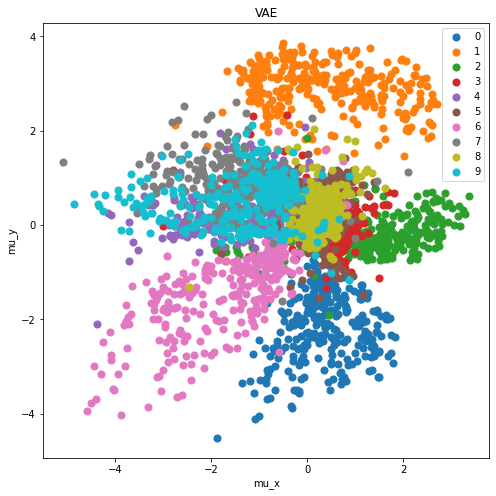

In [11]:
# get mu from vae and cvae
images, labels = data_x[:3000, ], data_y[:3000, ]
mu_vae = vae(images, training=False)[1].numpy()
mu_cvae = cvae(images, labels, training=False)[1].numpy()

# plot mu-distribution for vae
X, Y = mu_vae[:, 0], mu_vae[:, 1]
fig, ax = plt.subplots(figsize=(8, 8))
for i in np.arange(10):
    ix = np.where(labels == i)
    ax.scatter(X[ix], Y[ix], c='C'+str(i), label=i, s=50)
ax.legend()
plt.title('VAE')
plt.xlabel('mu_x')
plt.ylabel('mu_y')
plt.show()

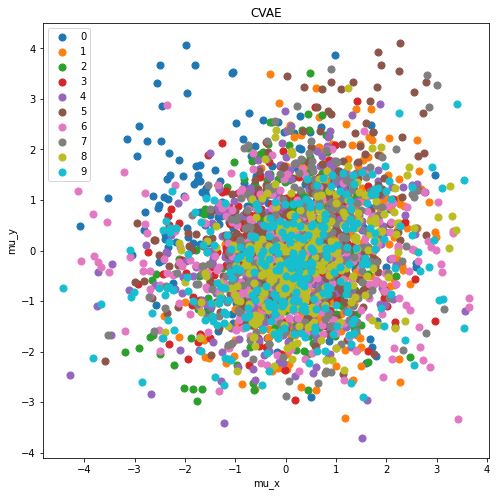

In [12]:
# plot the mu distribution for CVAE
X, Y = mu_cvae[:, 0], mu_cvae[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
for i in np.arange(10):
    ix = np.where(labels == i)
    ax.scatter(X[ix], Y[ix], c='C'+str(i), label=i, s=50)
ax.legend()
plt.title('CVAE')
plt.xlabel('mu_x')
plt.ylabel('mu_y')
plt.show()

###  Task 2: Visualize the decoding part

In [13]:
z = tf.random.normal([64, latent_size])
y = tf.random.uniform([64], 0, 10, dtype=tf.int32)

# vae
vae_out = vae.decode(z).numpy().reshape(-1, 1, 28, 28)
cvae_out_1 = cvae.decode(z, y).numpy().reshape(-1, 1, 28, 28)
cvae_out_2 = cvae.decode(z*0.4, y).numpy().reshape(-1, 1, 28, 28)

y = np.reshape(y.numpy(), (8,8))
print('Label information to guide CVAE:\n', np.matrix(y))

Label information to guide CVAE:
 [[5 6 3 5 1 7 6 9]
 [9 0 9 8 2 0 3 5]
 [4 9 5 3 8 8 6 1]
 [0 5 1 6 6 2 2 4]
 [3 5 0 5 2 9 3 6]
 [1 9 8 0 1 3 4 5]
 [4 7 6 5 1 6 5 7]
 [7 5 3 4 1 8 8 9]]


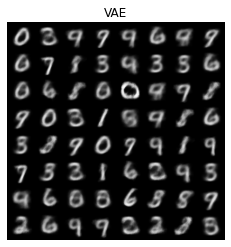

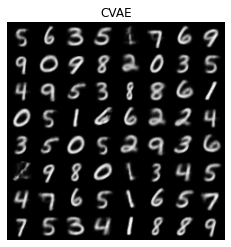

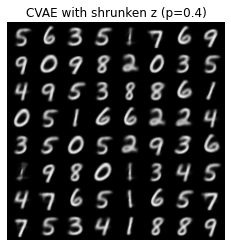

In [14]:
import torch
from torchvision.utils import save_image
import matplotlib.image as mpimg

vae_out, cvae_out_1, cvae_out_2 = map(
    torch.from_numpy, (vae_out, cvae_out_1, cvae_out_2))
save_image(vae_out, 'vae-sample_tf.png')
save_image(cvae_out_1, 'cvae-sample-1_tf.png')
save_image(cvae_out_2, 'cvae-sample-2_tf.png')

img = mpimg.imread('vae-sample_tf.png')
plt.axis('off')
plt.imshow(img)
plt.title('VAE')
plt.show()

img = mpimg.imread('cvae-sample-1_tf.png')
plt.axis('off')
plt.imshow(img)
plt.title('CVAE')
plt.show()

img = mpimg.imread('cvae-sample-2_tf.png')
plt.axis('off')
plt.imshow(img)
plt.title('CVAE with shrunken z (p=0.4)')
plt.show()